<a href="https://colab.research.google.com/github/doofenshirmtz/Data-Structures-in-C/blob/main/Fruits_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# 1. INSTALLATION (Always run this first in the cell)
!pip install -U ddgs fastai

# 2. IMPORTS
from ddgs import DDGS # The updated search library
from fastcore.all import *
from fastai.vision.all import * # Essential import for fastai, Path, download_images, etc.
import time
from pathlib import Path

# 3. FUNCTION DEFINITION (CORRECTED ARGUMENT NAME)
def search_images(keywords, max_images=200):
    "Searches for image URLs using the DDGS library."
    with DDGS() as ddgs:
        # **FIX: Changed 'keywords=keywords' to 'query=keywords'**
        search_results = ddgs.images(query=keywords)
        # Convert generator to list and slice it to the max_images limit
        results_list = list(search_results)[:max_images]
        # Extract only the 'image' URLs
        return L(results_list).itemgot('image')

# 4. EXECUTION LOOP
searches = 'gala apple photo', 'ripe banana photo', 'orange fruit photo'
path = Path('fruit_classifier')
max_images_per_category = 100

for o in searches:
    dest = (path/o)
    print(f"\n--- Starting to process: {o} ---")

    # Create the destination folder
    dest.mkdir(exist_ok=True, parents=True)

    # Search, Download, and Resize/Cleanup
    print(f"Searching for '{o}' images...")
    urls = search_images(o, max_images=max_images_per_category)

    print(f"Downloading {len(urls)} images to {dest}...")
    download_images(dest, urls=urls)

    print("Waiting 15 seconds to avoid ratelimiting...")
    time.sleep(15) # Essential delay

    print(f"Resizing and cleaning images in {dest}...")
    resize_images(path/o, max_size=400, dest=path/o)

print("\n--- All image data collected and preprocessed! ---")


--- Starting to process: gala apple photo ---
Searching for 'gala apple photo' images...
Waiting 15 seconds to avoid ratelimiting...
Resizing and cleaning images in fruit_classifier/gala apple photo...

--- Starting to process: ripe banana photo ---
Searching for 'ripe banana photo' images...
Waiting 15 seconds to avoid ratelimiting...
Resizing and cleaning images in fruit_classifier/ripe banana photo...

--- Starting to process: orange fruit photo ---
Searching for 'orange fruit photo' images...
Waiting 15 seconds to avoid ratelimiting...
Resizing and cleaning images in fruit_classifier/orange fruit photo...

--- All image data collected and preprocessed! ---


In [10]:
path = Path('fruit_classifier')
files = get_image_files(path)
print(f"Total files found in all folders: {len(files)}")

# Check files per folder
for folder in path.ls():
    if folder.is_dir():
        print(f"Files in {folder.name}: {len(get_image_files(folder))}")

Total files found in all folders: 58
Files in orange fruit photo: 20
Files in gala apple photo: 18
Files in ripe banana photo: 20


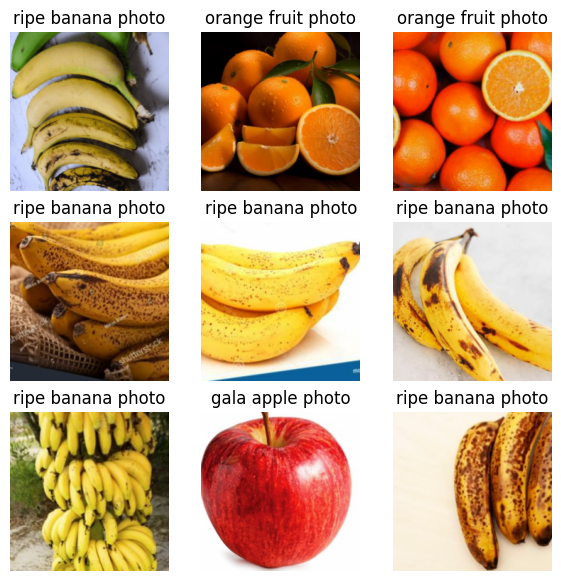

In [11]:
from fastai.vision.all import *

path = Path('fruit_classifier')

dls = DataBlock(
    # Input is an Image, Output is a Category (Label)
    blocks=(ImageBlock, CategoryBlock),
    # Find all image files recursively from the 'path' root directory
    get_items=get_image_files,
    # Split 80% for training and 20% for validation randomly
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # Get the label (y-value) from the name of the parent folder
    get_y=parent_label,
    # Resize all items to a larger size first
    item_tfms=Resize(460),
    # Apply standard data augmentation (resizing, cropping, rotating) to batches
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
# Create the DataLoaders (dls) from the root path
).dataloaders(path, bs=32) # Lowered batch size (bs) from 64 to 32 just in case, due to low total image count

# Verify that the DataLoaders now contain batches and show a sample
dls.show_batch(max_n=9, figsize=(7,7))

In [12]:
# 1. Create the Learner (Model)
# cnn_learner loads a pre-trained convolutional neural network (CNN)
learn = cnn_learner(
    dls,
    resnet18,                # The base model: ResNet-18 (good for quick training)
    metrics=error_rate       # The metric to track: percentage of incorrect predictions
)

# 2. Train the model using fine-tuning (4 epochs)
print("Starting fine-tuning...")
learn.fine_tune(4)

/usr/local/lib/python3.12/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 85.9MB/s]


Starting fine-tuning...


epoch,train_loss,valid_loss,error_rate,time
0,2.266387,1.866959,0.545455,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.813040,1.342509,0.545455,00:11
1,1.770998,0.562888,0.272727,00:11
2,1.401415,0.244367,0.090909,00:15
3,1.102094,0.154737,0.000000,00:13


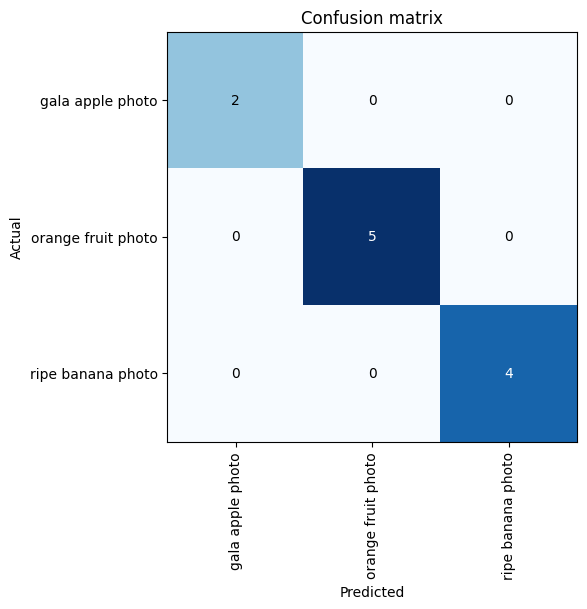

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

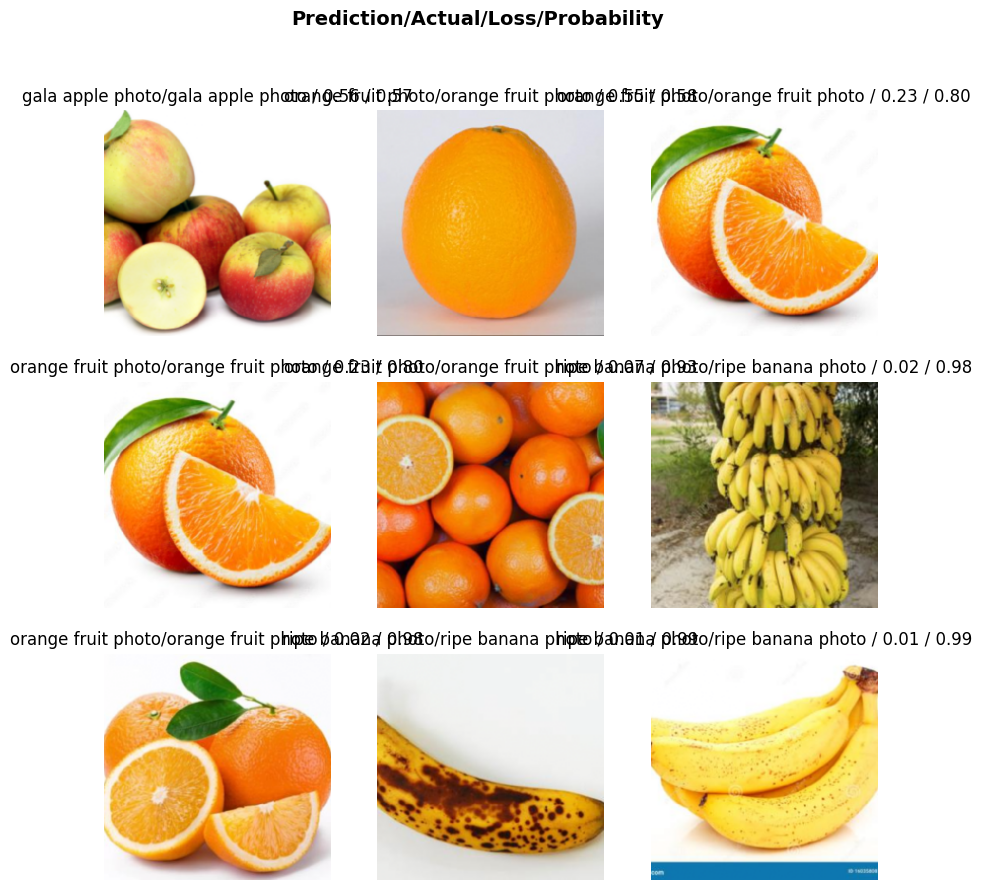

In [15]:
interp.plot_top_losses(9, figsize=(10, 10))

In [23]:
learn.export('fruit_classifier_final.pkl')
print("Model saved as fruit_classifier_final.pkl")

Model saved as fruit_classifier_final.pkl


/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")



--- Model Prediction ---
The model predicts this is a: ripe banana photo
Confidence in this prediction: 0.9454
All category scores: {'gala apple photo': 0.026764169335365295, 'orange fruit photo': 0.027857298031449318, 'ripe banana photo': 0.9453784823417664}


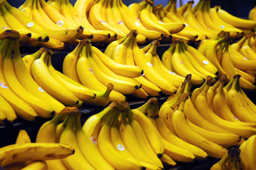

In [27]:
from fastai.vision.all import *
from pathlib import Path
from fastdownload import download_url # Make sure this is imported if you want to download a new test image

# Configuration
test_url = 'https://upload.wikimedia.org/wikipedia/commons/4/4c/Bananas.jpg'
test_filename = 'test_banana.jpg' # Use a unique filename
model_filename = 'fruit_classifier_final.pkl'

# Download the test image
download_url(test_url, test_filename, show_progress=False)

# Load the trained model from the saved file
learn = load_learner(model_filename)

# Make the prediction
is_fruit, pred_idx, probs = learn.predict(Path(test_filename))
confidence = probs[pred_idx]
all_probs = dict(zip(learn.dls.vocab, probs.tolist()))

print("\n--- Model Prediction ---")
print(f"The model predicts this is a: {is_fruit}")
print(f"Confidence in this prediction: {confidence:.4f}")
print(f"All category scores: {all_probs}")

# 6. Display the image for verification (This is the line that actually works)
Image.open(test_filename).to_thumb(256,256)